## **3. Generación de Lenguaje Natural**

Implementación de un **modelo de generación de lenguaje** utilizando algún dataset de los propuestos de **Twitter**.

El objetivo es el de **simular la creación de un bot que escriba tweets** de manera similar al del autor utilizado para el entrenamiento.

Se valorará principalmente la **argumentación de los pasos realizados y las conclusiones al analizar los resultados y limitaciones encontradas**.


Importamos las librerías y funciones que vamos a necesitar.

In [ ]:
import pandas as pd
import numpy as np
import pickle
import heapq

import matplotlib.pyplot as plt
%matplotlib inline
from pylab import rcParams
rcParams['figure.figsize'] = 12, 5

import tensorflow as tf

from copy import deepcopy

from keras.models import Sequential, load_model
from keras.layers import Dense, Activation
from keras.layers import LSTM, Dropout
from keras.layers import TimeDistributed
from keras.layers.core import Dense, Activation, Dropout, RepeatVector
from keras.optimizers import RMSprop
from keras.utils import np_utils

In [ ]:
# función que convierte el formato de la secuencia de entrada. Pasa de cadena de caracteres a entrada de nuestro modelo.
def prepare_input(text):
    text = text.lower()
    x = np.zeros((1, seq_length, len(chars)))

    for t, char in enumerate(text):
        x[0, t, char_indices[char]] = 1.
        
    return x

In [ ]:
def sample(preds, top_n=3):
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds)
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    
    return heapq.nlargest(top_n, range(len(preds)), preds.take)

In [ ]:
# función que genera la siguiente palabra
def predict_completion(text):
    original_text = text
    generated = text
    completion = ''
    while True:
        x = prepare_input(text)
        preds = model.predict(x, verbose=0)[0]
        next_index = sample(preds, top_n=1)[0]
        next_char = indices_char[next_index]

        text = text[1:] + next_char
        completion += next_char
        
        if len(original_text + completion) + 2 > len(original_text) and next_char == ' ':
            return completion

In [ ]:
# función qe genera el tweet
def generator_tweet(ini):
  input=ini
  text=input
  while len(text)<120:
    completion = predict_completion(input)
    text=text+completion
    input= text[-20:]
  return text

Montamos MyDrive

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


### **CARGA DE DATOS**

Para este ejercicio tomamos un conjunto de tweets de Neil de Grasse Tyson, un reconocido astrofísico estadounidense.

In [ ]:
data = pd.read_csv('drive/My Drive/BootcampBD&ML/práctica/prácticaNLP/datasets_241_800048_NeildeGrasseTysonTweets.csv', sep=',', decimal='.')
data.head()



Unnamed: 0  ...         author
0           0  ...  deGrasseTyson
1           1  ...  deGrasseTyson
2           2  ...  deGrasseTyson
3           3  ...  deGrasseTyson
4           4  ...  deGrasseTyson

[5 rows x 7 columns]

Nos quedamos simplemente con la columna text, que es el tweet generado por el autor.

In [ ]:
data = data[['text']]
data.describe()

text
count                                                2428
unique                                               2391
top     In 5-billion yrs the Sun will expand & engulf ...
freq                                                    5

Visualizamos a modo de ejemplo el primer tweet:

In [ ]:
data['text'][0]

'Moon’s shadow landfalls Oregon, crosses USA at 1800mph, exits SCarolina. Behold ‘Muuurica’s Eclipse.pic.twitter.com/fIMCnEyyQy'

Concatenamos todos los tweets para formar nuestro corpus de trabajo.

In [ ]:
text = ''
for i in range (0, len(data),1):
  text = text + data['text'][i]

#no paso a minúsculas porque al tratarse de generar texto, puede interesar que use mayúsculas para distinguir nombres propios o similar.
#pasa lo mismo con los hashtags y menciones, al querer generar texto nos puede interesar que los genere.
#text = text.lower()

print('corpus length: {}'.format(len(text)))

corpus length: 279443


### **MAPEO DE CARACTERES**

Creamos un par de diccionarios donde relacionamos cada caracter que aparece en el corpus con un índice:

In [ ]:
chars = sorted(list(set(text)))
char_indices = dict((c, i) for i, c in enumerate(chars))
indices_char = dict((i, c) for i, c in enumerate(chars))
#char_indices = {c:i for i, c in enumerate(chars)}
#indices_char = {i:c for c, c in enumerate(chars)}

print('unique chars: {}'.format(len(chars)))

unique chars: 106


In [ ]:
print(char_indices)

{'\n': 0, ' ': 1, '!': 2, '"': 3, '#': 4, '$': 5, '%': 6, '&': 7, "'": 8, '(': 9, ')': 10, '*': 11, '+': 12, ',': 13, '-': 14, '.': 15, '/': 16, '0': 17, '1': 18, '2': 19, '3': 20, '4': 21, '5': 22, '6': 23, '7': 24, '8': 25, '9': 26, ':': 27, ';': 28, '<': 29, '=': 30, '>': 31, '?': 32, '@': 33, 'A': 34, 'B': 35, 'C': 36, 'D': 37, 'E': 38, 'F': 39, 'G': 40, 'H': 41, 'I': 42, 'J': 43, 'K': 44, 'L': 45, 'M': 46, 'N': 47, 'O': 48, 'P': 49, 'Q': 50, 'R': 51, 'S': 52, 'T': 53, 'U': 54, 'V': 55, 'W': 56, 'X': 57, 'Y': 58, 'Z': 59, '[': 60, ']': 61, '^': 62, '_': 63, '`': 64, 'a': 65, 'b': 66, 'c': 67, 'd': 68, 'e': 69, 'f': 70, 'g': 71, 'h': 72, 'i': 73, 'j': 74, 'k': 75, 'l': 76, 'm': 77, 'n': 78, 'o': 79, 'p': 80, 'q': 81, 'r': 82, 's': 83, 't': 84, 'u': 85, 'v': 86, 'w': 87, 'x': 88, 'y': 89, 'z': 90, '\xa0': 91, '¢': 92, 'ä': 93, 'é': 94, 'ö': 95, 'ú': 96, 'ī': 97, '–': 98, '—': 99, '‘': 100, '’': 101, '“': 102, '”': 103, '…': 104, '⁰': 105}


### **PREPROCESADO**

Consideramos la longitud máxima de un tweet 140 caracteres, así que vamos a tomar 20 como la longitud de posibles frases o secuencias dentro de un tweet.
Además, el paso entre secuencias lo vamos a elegir igual a 1.

Como ya hemos dicho anteriormente, en este ejercicio de generación de texto no vamos a quitar mayúsculas, ni vamos a eliminar caracteres especiales como # o @, ya que podría interesar su uso para hacer posibles menciones. Buscamos si el model es capaz de crear los tweets de la forma más real posible.

In [ ]:
# Limit the sentences length to chunks of seq_length characters
seq_length = 20

# Spaces between sentences
step = 1

# List to store the sentences
sentences = []

# List to store the next character to be predicted for each sentence
next_chars = []
for i in range(0, len(text) - seq_length, step):
    sentences.append(text[i: i + seq_length])
    next_chars.append(text[i + seq_length])
print('num training examples: {}'.format(len(sentences)))

num training examples: 279423


De esta forma, para entender lo que estamos haciendo vamos a visualizar los 140 primeros caracteres del corpus y las 5 primeras secuencias:

In [ ]:
text[:140]

'Moon’s shadow landfalls Oregon, crosses USA at 1800mph, exits SCarolina. Behold ‘Muuurica’s Eclipse.pic.twitter.com/fIMCnEyyQy@huggy_panda  '

In [ ]:
sentences[:5]

['Moon’s shadow landfa',
 'oon’s shadow landfal',
 'on’s shadow landfall',
 'n’s shadow landfalls',
 '’s shadow landfalls ']

Ahora usamos la codificación one-hot-encoded y visualizamos un par de ejemplos para entender el proceso:

In [ ]:
# Create one-hot-encoded vectors
X = np.zeros((len(sentences), seq_length, len(chars)), dtype=np.bool)
y = np.zeros((len(sentences), len(chars)), dtype=np.bool)

for i, sentence in enumerate(sentences):
    for t, char in enumerate(sentence):
        X[i, t, char_indices[char]] = 1
    y[i, char_indices[next_chars[i]]] = 1

In [ ]:
# Mostramos la primera secuencia y el primer caracter a predecir 
print('Example of a single training sequence:\n {}\n'.format(sentences[0]))
print('Character to be predicted for it:\n {}'.format(next_chars[0]))

# Mostramos el número de secuencias de entrenamiento, la longitud de cada una de ellas, y el número de caractérres únicos que hay en el corpus
print('\nTraining examples:\t{}\nSequence length:\t{}\nUnique chars:\t\t{}'.format(X.shape[0], X.shape[1], X.shape[2]))
print('Primer caracter del corpus (X[0][0]):')
print(X[0][0])

# Mostramos el número de caracteres a predecir (uno por cada secuencia de entranamiento) y el número de caractérres únicos que hay en el corpus
print('\nCharacter to be predicted examples:\t{}\nUnique chars:\t\t{}'.format(y.shape[0], y.shape[1]))
print('Primer caracter a predecir (correspondiente a la primera secuencia) (y[0]):')
print(y[0])

Example of a single training sequence:
 Moon’s shadow landfa

Character to be predicted for it:
 l

Training examples:	279423
Sequence length:	20
Unique chars:		106
Primer caracter del corpus (X[0][0]):
[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False  True False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False]

Character to be predicted examples:	279423
Unique chars:		106
Primer caracter a predecir (correspondiente a la primera secuencia) (y[0]):
[False False

En este ejemplo vemos que el primer caracter del corpus (X[0][0]) es la "M" y se corresponde con el índice 46 y el primer caracter a predecir (y[0]) es la "l", que se corresponde con el índice 76. Ambas posiciones son las que están activadas con un True en las representaciones anteriores.

**DEFINIMOS UN PRIMER MODELO**

Empezamos con un primer **modelo muy sencillo** donde tenemos una capa LSTM, otra densa y una de activación.

La red LSTM (Long Short Term Memory) es adecuada para este tipo de ejercicio ya que se les da muy bien aprender de secuencias. Son un tipo especial de redes recurrentes. En  ellas la información persiste usando bucles en el diagrama de la red, por lo que, básicamente, pueden recordar estados previos y utilizar esta información para decidir cuál será el siguiente.

In [ ]:
vocab_size = len(chars)

model = Sequential()
model.add(LSTM(128, input_shape=(seq_length, len(chars))))
model.add(Dense(vocab_size))
model.add(Activation('softmax'))
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 128)               120320    
_________________________________________________________________
dense_1 (Dense)              (None, 106)               13674     
_________________________________________________________________
activation_1 (Activation)    (None, 106)               0         
Total params: 133,994
Trainable params: 133,994
Non-trainable params: 0
_________________________________________________________________
None


**ENTRENAMOS EL MODELO**

En esta primera aproximación solo lo entrenamos **durante 5 épocas**.

In [ ]:
# Set the optimizer
optimizer = RMSprop(lr=0.01)

# Compile the network
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Fit the network
history = model.fit(X, y, validation_split=0.05, batch_size=128, epochs=5, shuffle=True).history

Train on 265451 samples, validate on 13972 samples
Epoch 1/5
265451/265451 [==============================] - 126s 475us/step - loss: 2.2778 - accuracy: 0.3853 - val_loss: 2.1612 - val_accuracy: 0.4125
Epoch 2/5
265451/265451 [==============================] - 123s 465us/step - loss: 1.9385 - accuracy: 0.4692 - val_loss: 2.0744 - val_accuracy: 0.4345
Epoch 3/5
265451/265451 [==============================] - 125s 472us/step - loss: 1.8490 - accuracy: 0.4918 - val_loss: 2.0320 - val_accuracy: 0.4508
Epoch 4/5
265451/265451 [==============================] - 124s 466us/step - loss: 1.7996 - accuracy: 0.5062 - val_loss: 2.0218 - val_accuracy: 0.4520
Epoch 5/5
265451/265451 [==============================] - 124s 468us/step - loss: 1.7669 - accuracy: 0.5141 - val_loss: 2.0141 - val_accuracy: 0.4566


A continuación guardamos el modelo entrenado y el histórico, así en futuras simulaciones no hace falta volver a entrenarlo.

In [ ]:
# Save the model
model.save('drive/My Drive/BootcampBD&ML/práctica/prácticaNLP/model1.h5')
pickle.dump(history, open('drive/My Drive/BootcampBD&ML/práctica/prácticaNLP/history.p', 'wb'))

In [ ]:
# Load the model
model = load_model('drive/My Drive/BootcampBD&ML/práctica/prácticaNLP/model1.h5')
history = pickle.load(open('drive/My Drive/BootcampBD&ML/práctica/prácticaNLP/history.p', 'rb'))

 **EVALUACIÓN DEL MODELO SENCILLO CON 5 ÉPOCAS DE ENTRENAMIENTO**

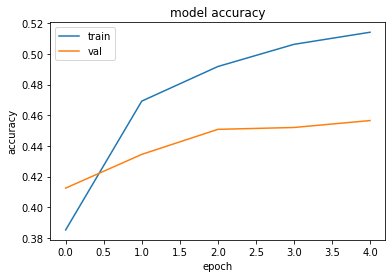

In [ ]:
# Model accuracy
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left');

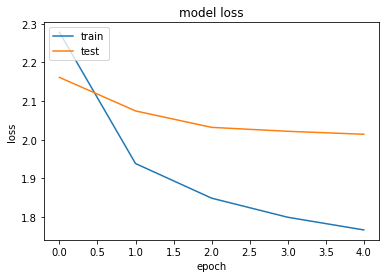

In [ ]:
# Model loss
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left');

Como punto de partida tomamos los valores de referencia y así podremos comparar con otros modelos. Accuracy del 45% y Loss de 1.7 en el bloque de validación.

**GENERACIÓN DE TWEETS CON EL MODELO SIMPLE (5 ÉPOCAS)**

In [ ]:
result = generator_tweet('my first example')
result

'my first example   tpei to the sunset to the sunset to the sunset to the sunset to the sunset to the sunset to the sunset '

In [ ]:
result = generator_tweet(sentences[0])
result

'Moon’s shadow landface of the strance of the strance of the strance of the strance of the strance of the strance of the '

Vemos que nuestro modelo genera texto aunque sea de una forma muy simple. Si prestamos atención se aprecia que termina repitiendo una misma secuencia: "to the sunset" o "of the strance".

**ENTRENAMOS EL MISMO MODELO CON MÁS ÉPOCAS**



In [ ]:
# Set the optimizer
optimizer = RMSprop(lr=0.01)

# Compile the network
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Fit the network
history = model.fit(X, y, validation_split=0.05, batch_size=128, epochs=25, shuffle=True).history

Train on 265451 samples, validate on 13972 samples
Epoch 1/25
265451/265451 [==============================] - 105s 397us/step - loss: 1.7455 - accuracy: 0.5196 - val_loss: 1.9992 - val_accuracy: 0.4623
Epoch 2/25
265451/265451 [==============================] - 106s 400us/step - loss: 1.7221 - accuracy: 0.5256 - val_loss: 2.0027 - val_accuracy: 0.4602
Epoch 3/25
265451/265451 [==============================] - 106s 399us/step - loss: 1.7064 - accuracy: 0.5300 - val_loss: 1.9914 - val_accuracy: 0.4676
Epoch 4/25
265451/265451 [==============================] - 106s 399us/step - loss: 1.6927 - accuracy: 0.5328 - val_loss: 2.0047 - val_accuracy: 0.4636
Epoch 5/25
265451/265451 [==============================] - 106s 399us/step - loss: 1.6813 - accuracy: 0.5362 - val_loss: 2.0135 - val_accuracy: 0.4641
Epoch 6/25
265451/265451 [==============================] - 106s 400us/step - loss: 1.6712 - accuracy: 0.5388 - val_loss: 1.9945 - val_accuracy: 0.4676
Epoch 7/25
265451/265451 [===========

In [ ]:
# Save the model
model.save('drive/My Drive/BootcampBD&ML/práctica/prácticaNLP/model2.h5')
pickle.dump(history, open('drive/My Drive/BootcampBD&ML/práctica/prácticaNLP/history2.p', 'wb'))

In [ ]:
# Load the model
model = load_model('drive/My Drive/BootcampBD&ML/práctica/prácticaNLP/model2.h5')
history = pickle.load(open('drive/My Drive/BootcampBD&ML/práctica/prácticaNLP/history2.p', 'rb'))

**EVALUACIÓN DEL MODELO SENCILLO CON 25 ÉPOCAS DE ENTRENAMIENTO**

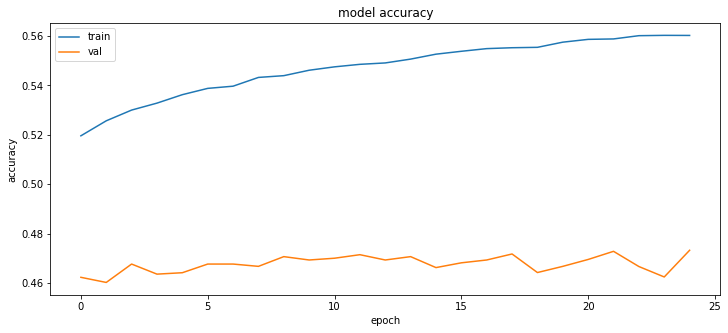

In [ ]:
# Model accuracy
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left');

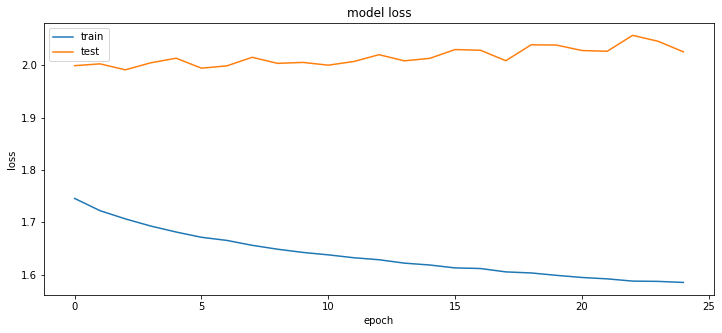

In [ ]:
# Model loss
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left');

Ha mejorado algo respecto al primer modelo, que solo habíamos entrenado durante 5 épocas, pero no mucho más. Se pude decir que prácticamente había convergido ya la red. Obtenemos en validación un Accuracy del 47% y unas Loss del 1.6.

**GENERACIÓN DE TWEETS CON EL MODELO SIMPLE (25 ÉPOCAS)**

In [ ]:
result = generator_tweet('my first example')
result

KeyboardInterrupt: ignored

No sé por qué falla, solo pasa con esta ejecución.

In [ ]:
result = generator_tweet(sentences[0])
result

'Moon’s shadow landfall the same to the sunset to the same to the sunset to the same to the sunset to the same to the sunset '

Aquí vemos un resultado similar al modelo anterior. Genera texto, en concreto son palabras que por sí mismas tienen significado pero simplemente las repite: "the same to the sunset to". Así que el resultado final no tiene coherencia.

Vamos a probar con un modelo más complejo a ver si mejoran las prestaciones.

**MODELO MÁS COMPLEJO**

En este caso usamos una capa más LSTM y ambas a su vez con más neuronas que en el caso anterior. Además añadimos a la salida de cada una de ellas una capa de dropout para controlar el overfitting.

In [ ]:
model = Sequential()
model.add(LSTM(512, input_shape=(seq_length, len(chars)), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(512))
model.add(Dropout(0.2))
model.add(Dense(vocab_size, activation='softmax'))
print(model.summary())

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_18 (LSTM)               (None, 20, 512)           1267712   
_________________________________________________________________
dropout_13 (Dropout)         (None, 20, 512)           0         
_________________________________________________________________
lstm_19 (LSTM)               (None, 512)               2099200   
_________________________________________________________________
dropout_14 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 106)               54378     
Total params: 3,421,290
Trainable params: 3,421,290
Non-trainable params: 0
_________________________________________________________________
None


**ENTRENAMOS EL MODELO COMPLEJO CON 10 ÉPOCAS**

In [ ]:
# Compile the network
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Fit the network
history = model.fit(X, y, validation_split=0.05, batch_size=32, epochs=10, shuffle=True).history

Train on 265451 samples, validate on 13972 samples
Epoch 1/10
265451/265451 [==============================] - 1186s 4ms/step - loss: 2.3873 - accuracy: 0.3548 - val_loss: 2.1230 - val_accuracy: 0.4195
Epoch 2/10
265451/265451 [==============================] - 1183s 4ms/step - loss: 1.8870 - accuracy: 0.4744 - val_loss: 1.9393 - val_accuracy: 0.4639
Epoch 3/10
265451/265451 [==============================] - 1186s 4ms/step - loss: 1.6949 - accuracy: 0.5213 - val_loss: 1.8659 - val_accuracy: 0.4853
Epoch 4/10
265451/265451 [==============================] - 1190s 4ms/step - loss: 1.5668 - accuracy: 0.5546 - val_loss: 1.8378 - val_accuracy: 0.4961
Epoch 5/10
265451/265451 [==============================] - 1185s 4ms/step - loss: 1.4717 - accuracy: 0.5782 - val_loss: 1.8434 - val_accuracy: 0.5040
Epoch 6/10
265451/265451 [==============================] - 1180s 4ms/step - loss: 1.3890 - accuracy: 0.5996 - val_loss: 1.8247 - val_accuracy: 0.5057
Epoch 7/10
265451/265451 [=================

In [ ]:
# Save the model
model.save('drive/My Drive/BootcampBD&ML/práctica/prácticaNLP/model3.h5')
pickle.dump(history, open('drive/My Drive/BootcampBD&ML/práctica/prácticaNLP/history3.p', 'wb'))

In [ ]:
# Load the model
model = load_model('drive/My Drive/BootcampBD&ML/práctica/prácticaNLP/model3.h5')
history = pickle.load(open('drive/My Drive/BootcampBD&ML/práctica/prácticaNLP/history3.p', 'rb'))

**EVALUACIÓN DEL MODELO COMPLEJO**

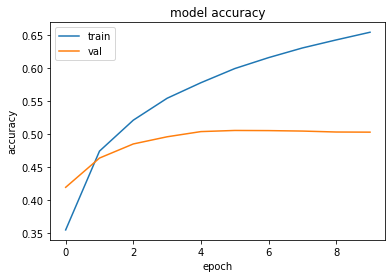

In [ ]:
# Model accuracy
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left');

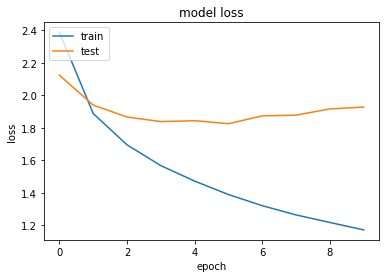

In [ ]:
# Model loss
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left');

Los valores obtenidos de accuracy y loss son mejores que los que teníamos con el modelo sencillo. Hemos pasado a un 50% y un 1.2 respectivamente. Podemos ver también como a partir de la quinta época los valores en validación ya no mejoran.

**GENERACIÓN DE TWEETS CON EL MODELO COMPLEJO**

In [ ]:
result = generator_tweet('my first example')
result

'my first example   sr the world where the Star side of the Universe is a science can stop a country that we can look a planet '

In [ ]:
result = generator_tweet(sentences[0])
result

'Moon’s shadow landfarces of the sky this night. Then you are train to a school.  In the sky this night. Then you are train '

Y analizando los tweets generados vemos como el modelo ha aprendido muy bien del dataset de train. Usa vocabulario muy frecuente en el corpus original como : Star, Universe, science, country, planet, sky, night...

Sin embargo las frases carecen de sentido. Seguramente esto se podría corregir entrenando modelos más complejos y durante más épocas, al igual que aumentando el tamaño de las secuencias, para tener una visión más amplia de la frase y no tres o cuatro palabras sueltas.

## **CONCLUSIONES**

Hemos visto como gracias a redes LSTM somos capaces de generar texto. Dependiendo de la complejidad y del grado de entrenamiento de dicha red este texto puede ser más o menos coherente.

En general vemos que se crean palabras y estas existen y están bien escritas. Además, se puede decir que usa vocabulario que ha aprendido en el dataset de train(en nuestro caso léxico relacionado con la astrofísica). En los modelos más simples solo es capaz de repetir una secuencia de palabras, y con un modelo algo más complejo es capaz de forma frases aparentemente correctas en cuanto a forma, pero no en el fondo, ya que no tienen significado.
Tampoco ha sido capaz de incorporar menciones, enlaces o hashtags, que fue una consideración que se tuvo en el preprocesado (no eliminar esos símbolos: @, #).